<a href="https://colab.research.google.com/github/Rhqo/Toy-Models-of-Superposition/blob/main/KBH_Toy_Models_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My_Toy_Models
Class 정의, 모델 정의, 함수 정의 등 논문에 있는 코드 활용

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Optional
import numpy as np
from tqdm import trange
import time
import einops
import matplotlib.pyplot as plt
import math

In [2]:
# 디바이스 체크
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class Config:
    def __init__(self, n_features: int, n_hidden: int, n_instances: int):
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_instances = n_instances

class Model(nn.Module):
    def __init__(self,
                config,
                activation=True,
                feature_probability: Optional[torch.Tensor] = None,
                importance: Optional[torch.Tensor] = None,
                device='cuda'):
        super().__init__()
        self.config = config
        self.activation = activation
        self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [..., instance, n_features]
        # W: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b_final
        if self.activation:
            out = F.relu(out)
        return out

    def hidden(self, features):
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        return hidden

    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
        batch = torch.where(
            torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
            feat,
            torch.zeros((), device=self.W.device),
        )
        return batch

def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      loss.backward()
      opt.step()

      if hooks:
        hook_data = dict(model=model,
                         step=step,
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )

# How about more high-dimensions?


## 5D to 3D (1-S = [0, 0.3, 0.6, 0.9, 0.999])

In [4]:
# 설정
config = Config(
    n_features=4,  # 특징 수
    n_hidden=3,    # 은닉 차원 수 (2D로 투영)
    n_instances=1,  # 데이터 인스턴스 수
)

# 희소성 파라미터 S (xi가 0일 확률, [0, 1))
train_sparsity = [0, 0.3, 0.6, 0.9, 0.999]

In [5]:
# 모델 정의
models = []
for i in range(5):
    model = Model(
        config=config,
        activation=True,
        device=DEVICE,
        importance=(1 ** torch.arange(config.n_features))[None, :],
        feature_probability=torch.full((config.n_instances, 1), 1-train_sparsity[i])
    )
    models.append(model)
    # 모델 학습
    optimize(model)

100%|██████████| 10000/10000 [00:19<00:00, 501.96it/s, loss=1.16e-10, lr=0.001]


### $S = \text{test sparsity}$
인 test data로 inference

In [6]:
# 특정 sparsity 데이터 생성
test_sparsity = 0.9
n_batch = 10000
x = torch.rand((n_batch, config.n_instances, config.n_features), device=DEVICE)
mask = torch.rand((n_batch, config.n_instances, config.n_features), device=x.device) <= 1-test_sparsity
values = torch.rand((n_batch, config.n_instances, config.n_features), device=x.device)
x = torch.where(mask, values, torch.zeros_like(x))

x_reshape = x.reshape(-1, config.n_features)

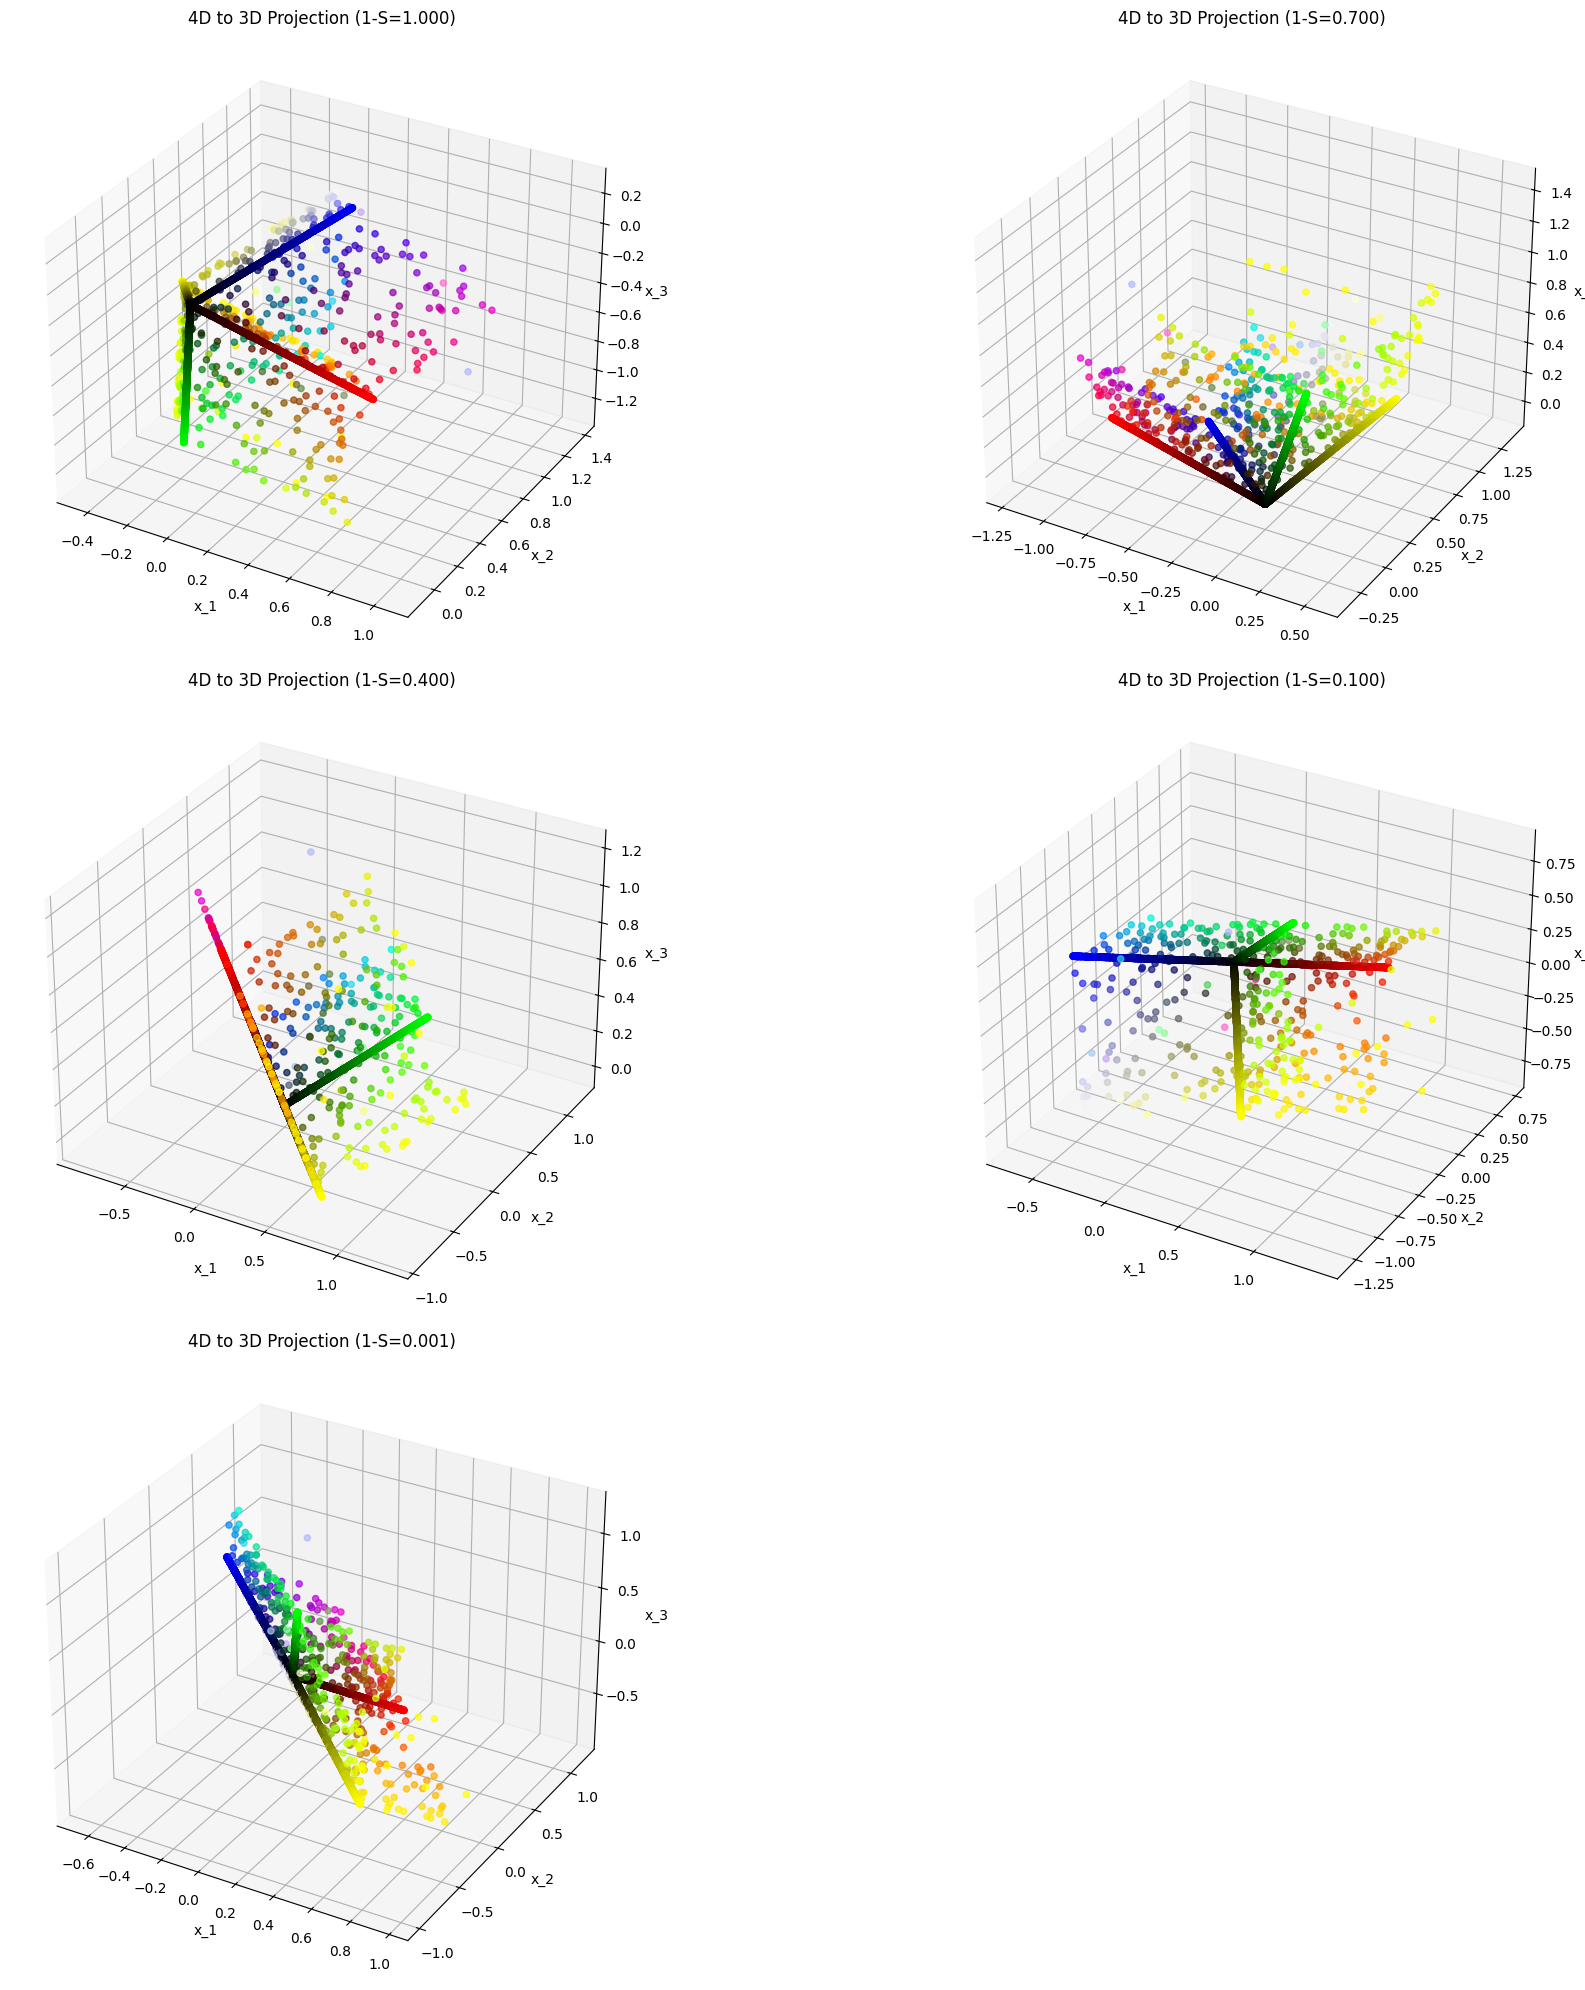

In [7]:
x_min = x_reshape.min(dim=0, keepdim=True).values  # (1, 5)
x_max = x_reshape.max(dim=0, keepdim=True).values  # (1, 5)
x_normalized = (x_reshape - x_min) / (x_max - x_min + 1e-8)  # 정규화 (0~1) 범위로 변환

# 색상 맵 정의
colors_map = [
    [1, 0, 0],    # 빨강 (Red)
    [0, 0, 1],    # 파랑 (Blue)
    [0, 1, 0],    # 초록 (Green)
    [1, 1, 0],    # 노랑 (Yellow)
]

# 5차원 데이터의 각 차원에 대해 색상 가중치를 적용하여 3차원 색상으로 매핑
colors = torch.zeros((x_normalized.shape[0], 3), device=DEVICE)  # (100, 3) 크기의 색상 벡터
for i in range(4):
    colors += x_normalized[:, i].unsqueeze(1) * torch.tensor(colors_map[i], device=DEVICE)

colors = colors.clip(0, 1).cpu().numpy()


# 3D 시각화
fig = plt.figure(figsize=(20, 20))

for i in range(5):
    with torch.no_grad():
        x_hidden = models[i].hidden(x).reshape(-1, config.n_hidden).cpu().numpy()
    ax = fig.add_subplot(3, 2, i + 1, projection='3d')
    ax.scatter(x_hidden[:, 0], x_hidden[:, 1], x_hidden[:, 2], c=colors, alpha=0.7)
    ax.set_title(f'4D to 3D Projection (1-S={1-train_sparsity[i]:.3f})')
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('x_3')

plt.tight_layout()
plt.show()


In [8]:
import plotly.graph_objects as go  # Plotly 라이브러리 추가

for i in range(5):
    with torch.no_grad():
        x_hidden = models[i].hidden(x).reshape(-1, config.n_hidden).cpu().numpy()
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=x_hidden[:, 0], y=x_hidden[:, 1], z=x_hidden[:, 2], mode='markers', marker=dict(size=2, color=colors, opacity=0.7)))
    fig.update_layout(title=f'4D to 3D Projection (1-S={1-train_sparsity[i]:.3f})', scene=dict(xaxis_title='x_1', yaxis_title='x_2', zaxis_title='x_3'))
    fig.show()

## 5D to 3D (1-S = [0, 0.3, 0.6, 0.9, 0.999])

In [ ]:
# 설정
config = Config(
    n_features=4,  # 특징 수
    n_hidden=3,    # 은닉 차원 수 (2D로 투영)
    n_instances=1,  # 데이터 인스턴스 수
)

# 희소성 파라미터 S (xi가 0일 확률, [0, 1))
train_sparsity = [0, 0.3, 0.6, 0.9, 0.999]

In [ ]:
# 모델 정의
models = []
for i in range(5):
    model = Model(
        config=config,
        activation=True,
        device=DEVICE,
        importance=(0.7 ** torch.arange(config.n_features))[None, :],
        feature_probability=torch.full((config.n_instances, 1), 1-train_sparsity[i])
    )
    models.append(model)
    # 모델 학습
    optimize(model)

100%|██████████| 10000/10000 [00:15<00:00, 650.68it/s, loss=1.53e-10, lr=0.001]


### $S = \text{test sparsity}$
인 test data로 inference

In [ ]:
# 특정 sparsity 데이터 생성
test_sparsity = 0.9
n_batch = 10000
x = torch.rand((n_batch, config.n_instances, config.n_features), device=DEVICE)
mask = torch.rand((n_batch, config.n_instances, config.n_features), device=x.device) <= 1-test_sparsity
values = torch.rand((n_batch, config.n_instances, config.n_features), device=x.device)
x = torch.where(mask, values, torch.zeros_like(x))

x_reshape = x.reshape(-1, config.n_features)

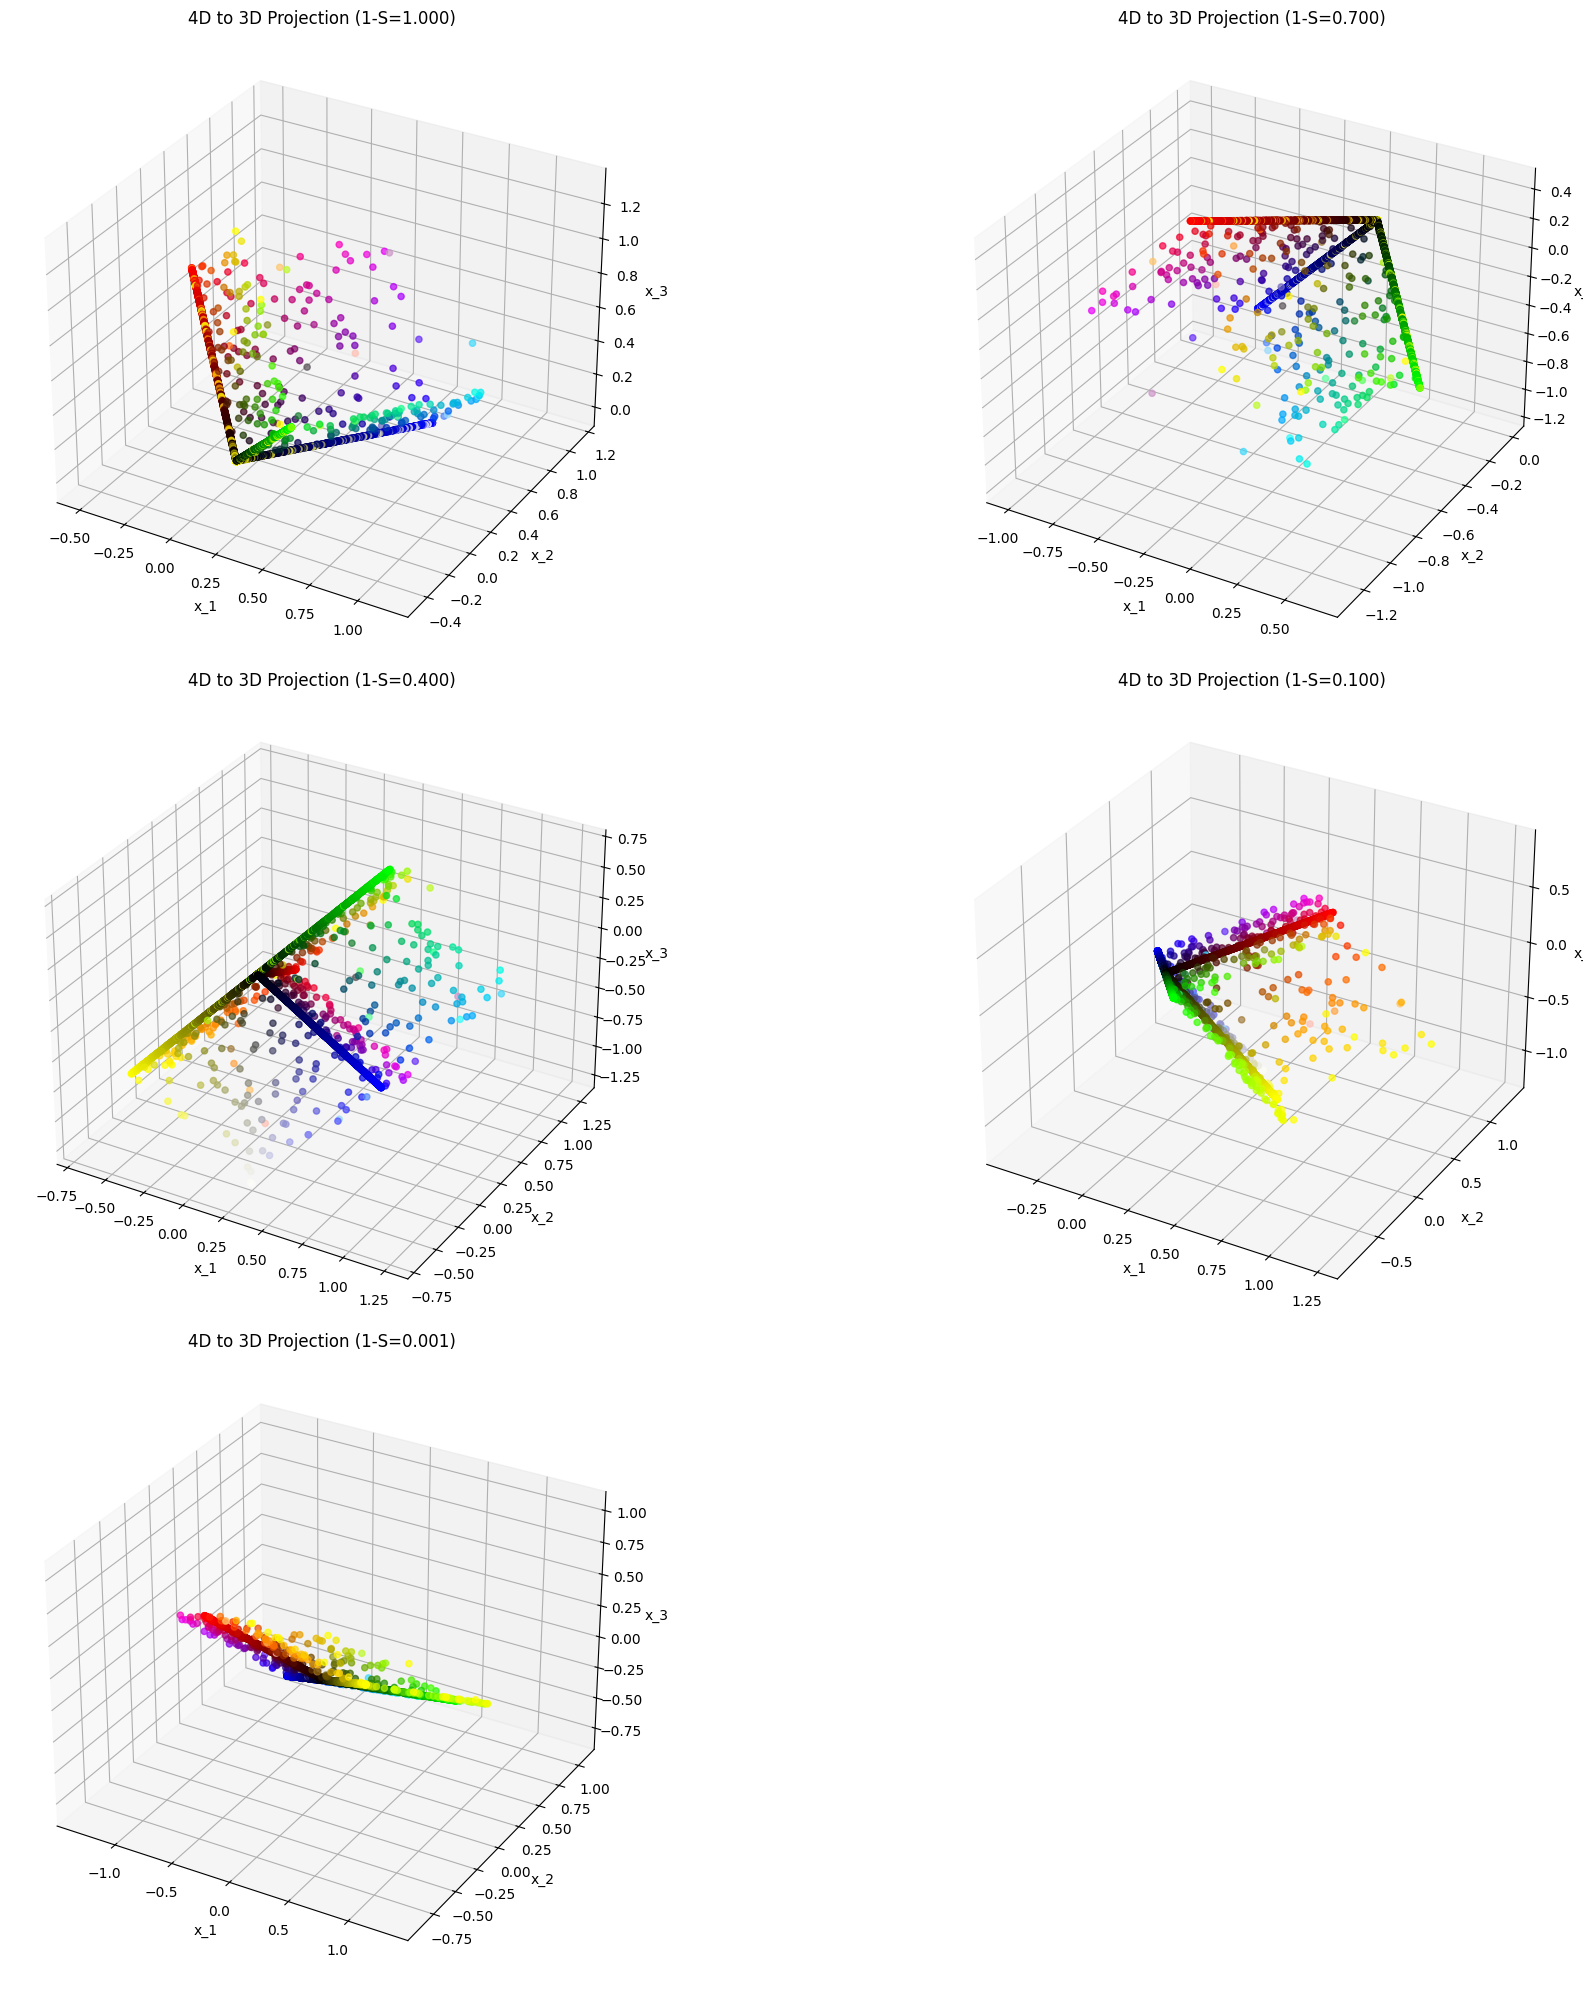

In [ ]:
x_min = x_reshape.min(dim=0, keepdim=True).values  # (1, 5)
x_max = x_reshape.max(dim=0, keepdim=True).values  # (1, 5)
x_normalized = (x_reshape - x_min) / (x_max - x_min + 1e-8)  # 정규화 (0~1) 범위로 변환

# 색상 맵 정의
colors_map = [
    [1, 0, 0],    # 빨강 (Red)
    [0, 0, 1],    # 파랑 (Blue)
    [0, 1, 0],    # 초록 (Green)
    [1, 1, 0],    # 노랑 (Yellow)
]

# 5차원 데이터의 각 차원에 대해 색상 가중치를 적용하여 3차원 색상으로 매핑
colors = torch.zeros((x_normalized.shape[0], 3), device=DEVICE)  # (100, 3) 크기의 색상 벡터
for i in range(4):
    colors += x_normalized[:, i].unsqueeze(1) * torch.tensor(colors_map[i], device=DEVICE)

colors = colors.clip(0, 1).cpu().numpy()


# 3D 시각화
fig = plt.figure(figsize=(20, 20))

for i in range(5):
    with torch.no_grad():
        x_hidden = models[i].hidden(x).reshape(-1, config.n_hidden).cpu().numpy()
    ax = fig.add_subplot(3, 2, i + 1, projection='3d')
    ax.scatter(x_hidden[:, 0], x_hidden[:, 1], x_hidden[:, 2], c=colors, alpha=0.7)
    ax.set_title(f'4D to 3D Projection (1-S={1-train_sparsity[i]:.3f})')
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('x_3')

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go  # Plotly 라이브러리 추가

for i in range(5):
    with torch.no_grad():
        x_hidden = models[i].hidden(x).reshape(-1, config.n_hidden).cpu().numpy()
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=x_hidden[:, 0], y=x_hidden[:, 1], z=x_hidden[:, 2], mode='markers', marker=dict(size=2, color=colors, opacity=0.7)))
    fig.update_layout(title=f'4D to 3D Projection (1-S={1-train_sparsity[i]:.3f})', scene=dict(xaxis_title='x_1', yaxis_title='x_2', zaxis_title='x_3'))
    fig.show()